## Prove di altri grafi post colloquio col prof

In [5]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import os
from IPython.display import display
import itertools
import plotly.graph_objects as go
import scipy
import re

df=pd.read_csv("nuovo_dataset.csv")
df["authors_list"] = df["Authors"].str.split(",")
df["authors_list"] = df["authors_list"].apply(
    lambda x: [a.strip() for a in x] if isinstance(x, list) else x
)

# assicura che Year sia numerico
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
grafi_per_anno = {}
for anno, df_anno in df.groupby("Year"):
    G = nx.Graph()
    for authors in df_anno["authors_list"].dropna():
        for a1, a2 in itertools.combinations(authors, 2):
            if G.has_edge(a1, a2):
                G[a1][a2]["weight"] += 1
            else:
                G.add_edge(a1, a2, weight=1)
    grafi_per_anno[anno] = G

Nodo più centrale: M.
Grado: 148
Betweenness: 0.362


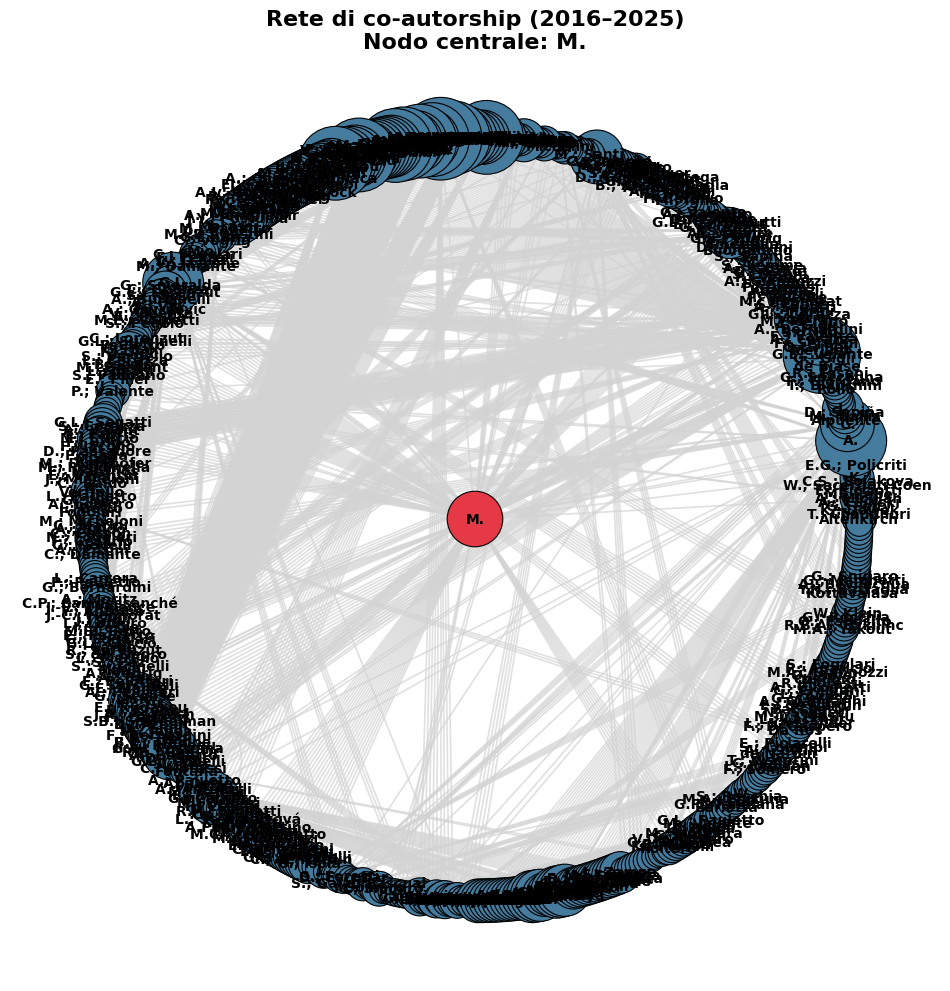

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# =========================
# 1️⃣ Grafo complessivo (2016–2025)
# =========================
G = nx.compose_all(grafi_per_anno.values())

# =========================
# 2️⃣ Calcolo delle centralità
# =========================
degree = dict(G.degree())
betweenness = nx.betweenness_centrality(G)

# nodo più centrale (grado massimo)
central_node = max(degree, key=degree.get)

print("Nodo più centrale:", central_node)
print("Grado:", degree[central_node])
print("Betweenness:", round(betweenness[central_node], 3))

# =========================
# 3️⃣ Layout circolare + nodo centrale al centro
# =========================
others = [n for n in G.nodes() if n != central_node]

# disposizione circolare per gli altri nodi
theta = np.linspace(0, 2*np.pi, len(others), endpoint=False)
radius = 3

pos = {central_node: (0, 0)}
for node, angle in zip(others, theta):
    pos[node] = (radius * np.cos(angle), radius * np.sin(angle))

# =========================
# 4️⃣ Colori e dimensioni
# =========================
node_colors = []
node_sizes = []

for n in G.nodes():
    if n == central_node:
        node_colors.append("#E63946")   # rosso acceso
        node_sizes.append(1600)         # molto grande
    else:
        node_colors.append("#457B9D")   # blu elegante
        node_sizes.append(300 + degree[n] * 30)

# =========================
# 5️⃣ Disegno del grafo (grafica figa)
# =========================
plt.figure(figsize=(12, 12))
plt.axis("off")

# archi
nx.draw_networkx_edges(
    G, pos,
    edge_color="lightgray",
    width=1.2,
    alpha=0.7
)

# nodi
nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    node_size=node_sizes,
    edgecolors="black",
    linewidths=0.8
)

# etichette SOLO per i nodi più importanti
labels = {n: n for n in G.nodes() if degree[n] >= 5}
labels[central_node] = central_node

nx.draw_networkx_labels(
    G, pos,
    labels,
    font_size=10,
    font_weight="bold"
)

# =========================
# 6️⃣ Titolo finale
# =========================
plt.title(
    "Rete di co‑autorship (2016–2025)\n"
    f"Nodo centrale: {central_node}",
    fontsize=16,
    fontweight="bold"
)

plt.show()


# Autori e keyword
Analisis con vari layout e prove di filtro per centralità.

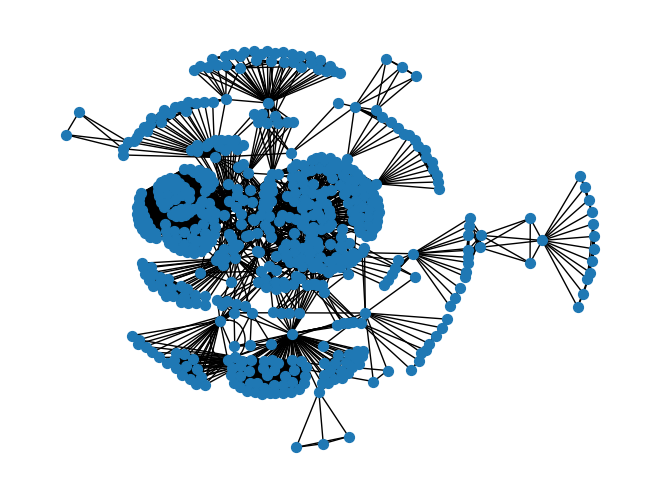

In [7]:

import re

def split_keywords(x):
    if pd.isna(x):
        return []
    return [k.strip() for k in re.split(r'[;,|]', x) if k.strip()]

df["author_kw_list"] = df["Author Keywords"].apply(split_keywords)
df["index_kw_list"] = df["Index Keywords"].apply(split_keywords)

df["all_keywords"] = df.apply(
    lambda row: list(set(row["author_kw_list"] + row["index_kw_list"])),
    axis=1
)

G_kw = nx.Graph()

for _, row in df.iterrows():
    article = row["Title"]
    keywords = row["all_keywords"]

    for kw in keywords:
        G_kw.add_node(article, type="article")
        G_kw.add_node(kw, type="keyword")
        G_kw.add_edge(article, kw)

G_prof_kw = nx.Graph()

for _, row in df.iterrows():
    authors = row["authors_list"]
    keywords = row["all_keywords"]

    if not isinstance(authors, list):
        continue

    for a in authors:
        for kw in keywords:
            G_prof_kw.add_node(a, type="author")
            G_prof_kw.add_node(kw, type="keyword")
            G_prof_kw.add_edge(a, kw)

def filter_by_centrality(G, threshold=0.03):
    centrality = nx.degree_centrality(G)
    nodes_to_keep = [n for n, c in centrality.items() if c >= threshold]
    return G.subgraph(nodes_to_keep).copy(), centrality


def draw_kamada(G, centrality, title):
    pos = nx.kamada_kawai_layout(G)

    sizes = [centrality[n] * 2000 for n in G.nodes()]
    colors = [
        "gold" if G.nodes[n]["type"]=="article" else
        "skyblue" if G.nodes[n]["type"]=="author" else
        "purple"
        for n in G.nodes()
    ]

    plt.figure(figsize=(16,14))
    nx.draw(
        G, pos,
        node_size=sizes,
        node_color=colors,
        with_labels=False,
        alpha=0.85
    )

    labels = {
        n: n for n in G.nodes()
        if centrality[n] >= sorted(centrality.values())[-10]  # top 10
    }

    nx.draw_networkx_labels(G, pos, labels, font_size=9)
    plt.title(title)
    plt.show()

pos = nx.kamada_kawai_layout(G, weight=None)
nx.draw(G, pos, node_size=50, with_labels=False)
plt.show()


=== Layout: spring ===


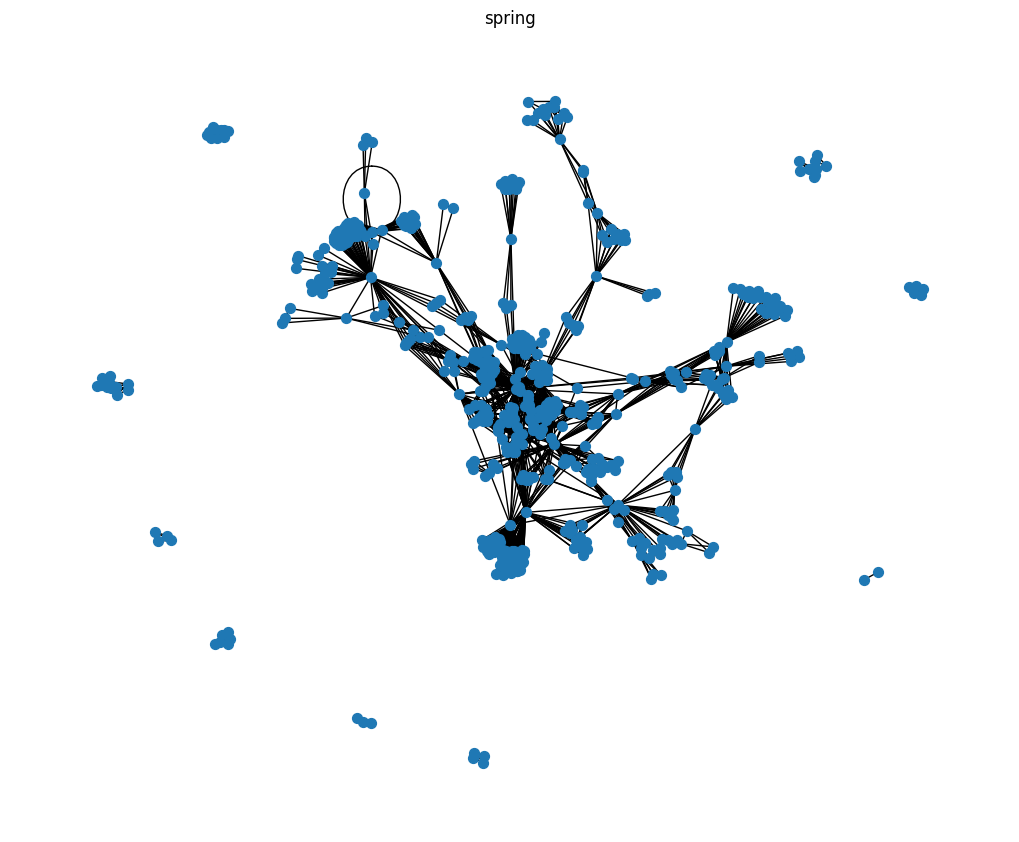


=== Layout: kamada_kawai ===


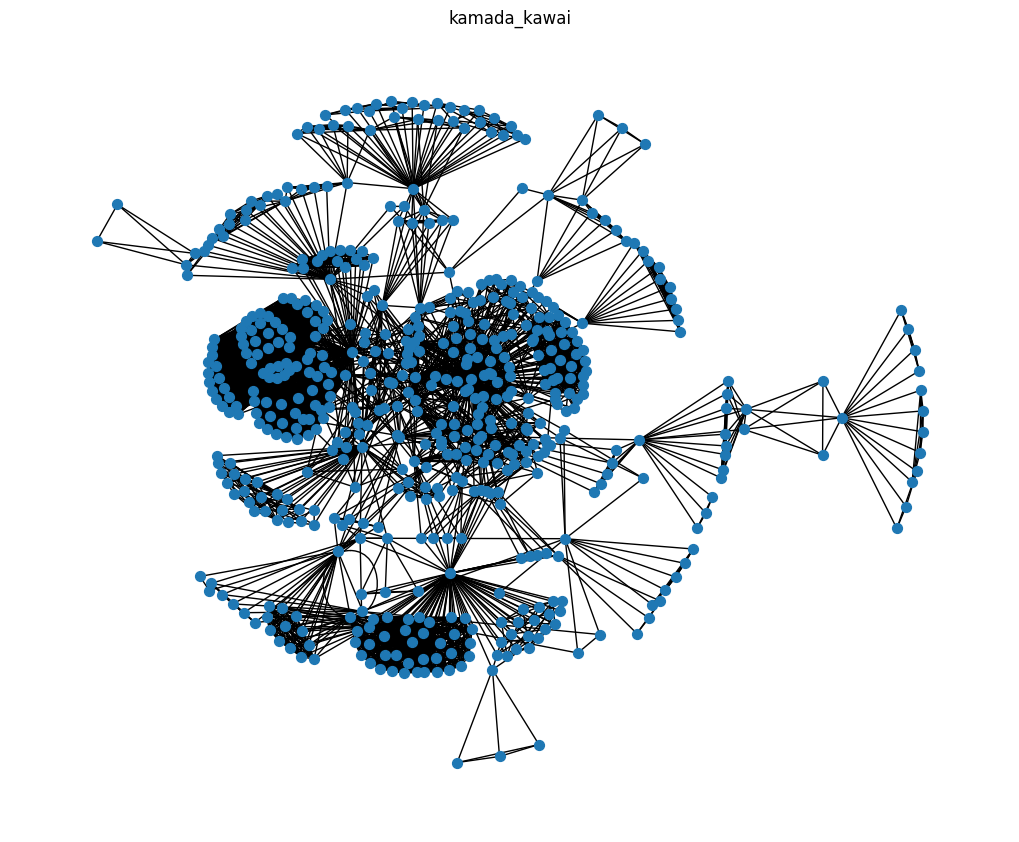


=== Layout: circular ===


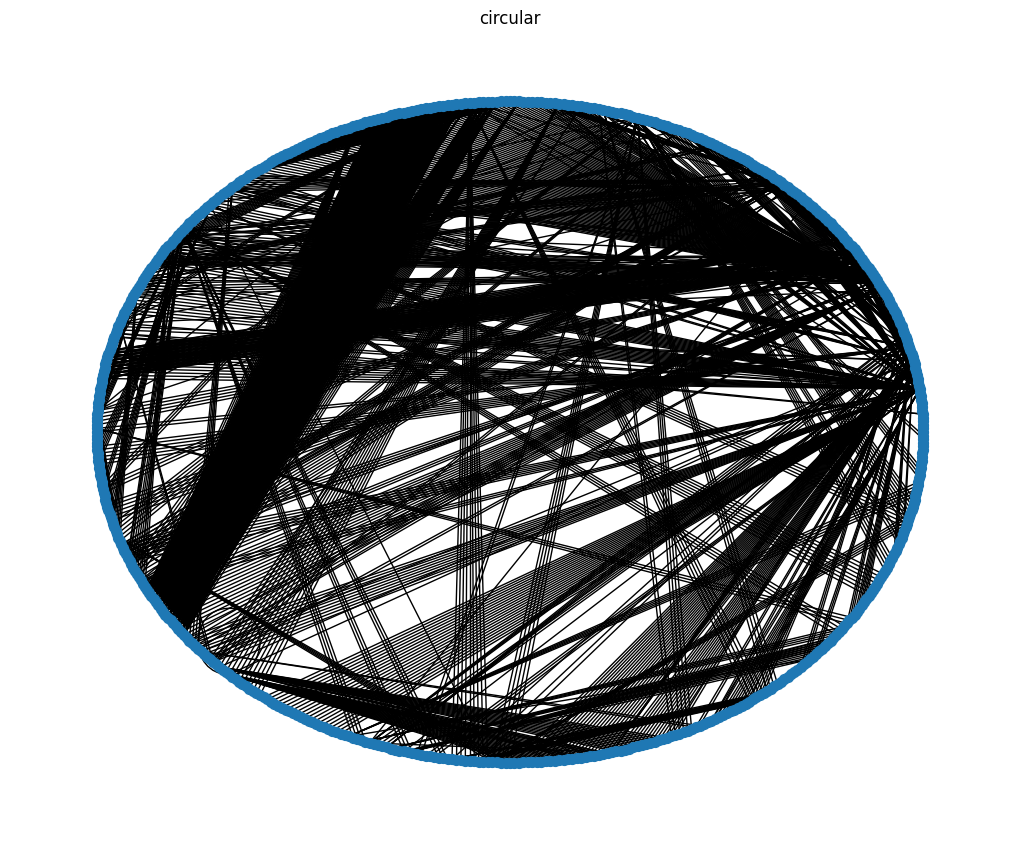


=== Layout: shell ===
Errore nel layout shell: name 'articles' is not defined

=== Layout: spectral ===


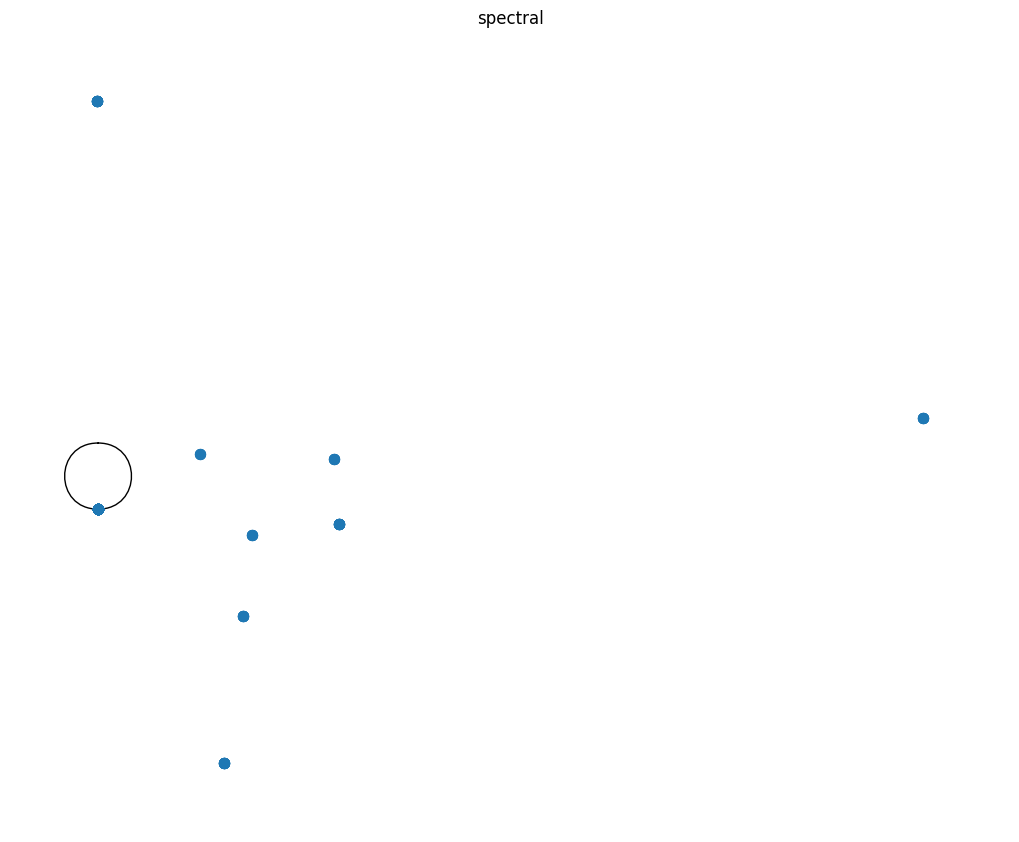


=== Layout: spiral ===


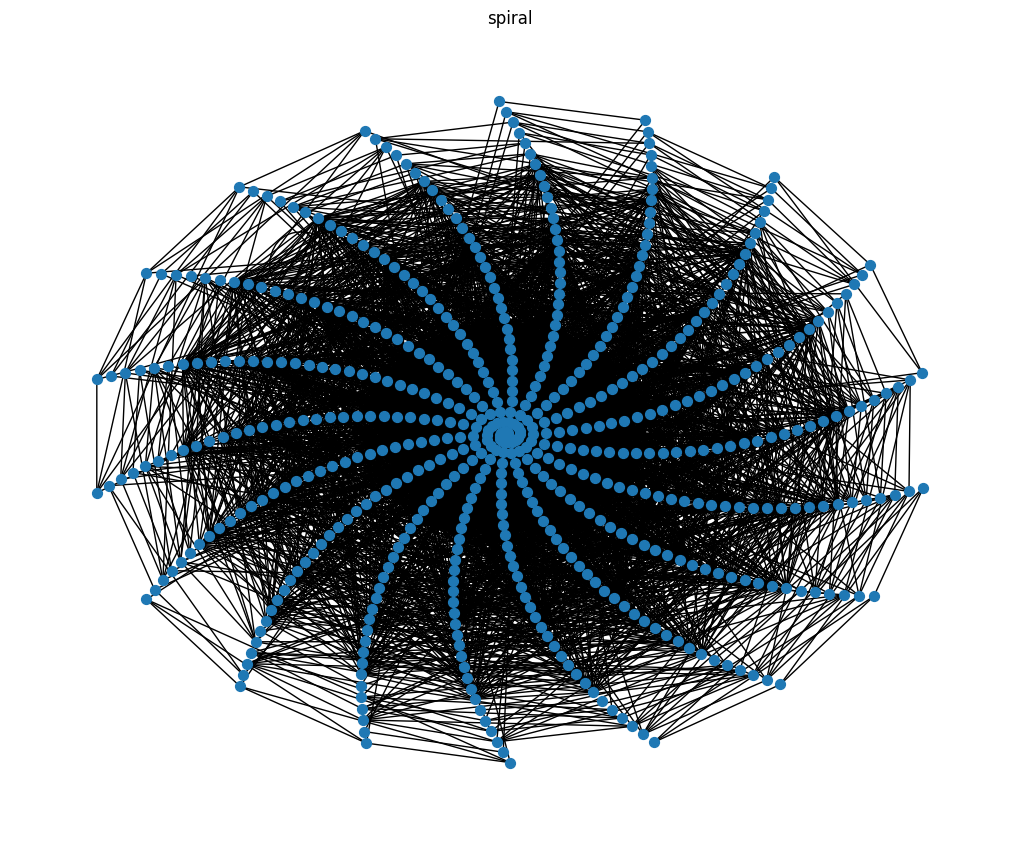

In [26]:
layouts = {
    "spring": nx.spring_layout,
    "kamada_kawai": nx.kamada_kawai_layout,
    "circular": nx.circular_layout,
    "shell": lambda G: nx.shell_layout(G, nlist=[keywords, articles]),
    "spectral": nx.spectral_layout,
    "spiral": nx.spiral_layout
}

for name, layout in layouts.items():
    try:
        print(f"\n=== Layout: {name} ===")
        pos = layout(G)
        plt.figure(figsize=(10,8))
        nx.draw(G, pos, node_size=50, with_labels=False)
        plt.title(name)
        plt.show()
    except Exception as e:
        print(f"Errore nel layout {name}: {e}")